### 데이콘 비트코인 가격 예측 - Prophet

In [1]:
import os, datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

import IPython
import IPython.display
import matplotlib.pyplot as plt

from neuralprophet import NeuralProphet
import preprocessor, coin_simulation

# modeling programing
def neural_prophet_modeling(input_array):
    ''' 함수 설명 : prophet fitting & prediction'''
    
    #미래 데이터 저장을 위한 빈 array 생성
    valid_pred_array =  np.zeros([input_array.shape[0], 120])
    error_counter = 0
    
    #모델 돌리기 및 결과 저장
    for idx in tqdm(range(input_array.shape[0])):
        try:
            x_series = input_array[idx,:].reshape(-1)
            x_df = prophet_preprocessor(x_series)

            model = NeuralProphet(
                          n_changepoints = 20,
                          d_hidden = 30,
                          changepoints_range = 0.95,
                          num_hidden_layers = 1,

                          learning_rate = 0.1, epochs=40, batch_size = 32, loss_func="Huber",
                          seasonality_mode = 'multiplicative',
                          yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False,
                          normalize='off' # Type of normalization ('minmax', 'standardize', 'soft', 'off')
                         )
    
            model.add_seasonality(name='first_seasonality', period=1/24, fourier_order= 7 ) 
            model.add_seasonality(name='second_seasonality', period=1/12, fourier_order= 15)

            metrics = model.fit(x_df, freq="min")

            future = model.make_future_dataframe(x_df, periods=120)
            forecast = model.predict(future)
    
            valid_pred_array[idx,:] = forecast.yhat1.values[-120:]
            IPython.display.clear_output()
            
        except:
            error_counter += 1
            print(f'Neural Prophet modeling error!')
            IPython.display.clear_output()
            pass
    
    # clear display
    IPython.display.clear_output()
    print(f'''
    NOTE : {len(input_array)}의 샘플 내 {error_counter}개의 샘플에서 에러가 발생했습니다.\n
    Prediction Complete!'
    '''
    )        

    return valid_pred_array

def prophet_preprocessor(x_series):
    ''' 함수 설명 : 빈 x_df 만들기'''
    # start time initialization
    start_time = '2021-01-01 00:00:00'
    start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

    # datafram 만들기
    x_df = pd.DataFrame()
    # 분당 시간 데이터 시리즈 입력
    x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
    # 가격 데이터 시리즈 입력
    x_df['y'] = x_series.tolist()

    return x_df

In [2]:
### ------------ Data upload part ---------------- ###

# 데이터가 위치한 폴더 경로
dir_path = './data'

# 파일명 설정
x_file_name, y_file_name = 'train_x_df.csv', 'train_y_df.csv'
x_file_path = os.path.join(dir_path, x_file_name)
y_file_path = os.path.join(dir_path, y_file_name)

#파일 업로드
train_x_df = pd.read_csv(x_file_path)
train_y_df = pd.read_csv(y_file_path)
print("Reading Complete!")



### --------------- Modeling part ---------------- ###

# 데이터 전처리 1 : dafaframe to array 
train_x_array = preprocessor.df2d_to_array3d(train_x_df)
train_y_array = preprocessor.df2d_to_array3d(train_y_df)

# 데이터 전처리 2 : 실수 차분(Fractional Differencing)
FFD_train_x_array = preprocessor.FFD_smoothing(train_x_array) #자동으로 383개만 추출 시켜둠.

# 데이터 전처리 2-2 : 비차분 open 데이터 추출
# normal_x_array = train_x_array[:383, :, 1].reshape(383, 1380, 1) # open col is 1

Reading Complete!


In [3]:
print(1232131)

1232131


In [4]:
# 모델링 시작
valid_pred_array = neural_prophet_modeling(FFD_train_x_array)
save_file_name = 'FFD_neural_prophet_result2.csv'
np.savetxt(save_file_name, valid_pred_array, delimiter = ",")



    NOTE : 383의 샘플 내 0개의 샘플에서 에러가 발생했습니다.

    Prediction Complete!'
    


In [50]:
import profit_function

# arguments : pred array, start_idx, increase_rate
valid_submission = profit_function.array_to_submission(valid_pred_array, start_idx = 0, increase_rate = 1.01)
valid_y_array = train_y_array[:383, :, 1]
total_money, total_money_list = profit_function.COIN(y_array=valid_y_array, submission=valid_submission)

11406.797940622964


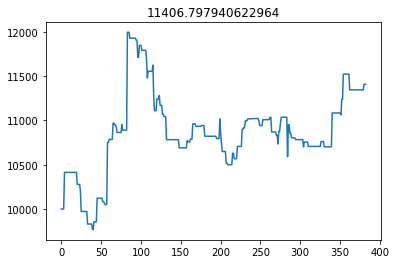

In [51]:
print(total_money)
plt.plot(total_money_list)
plt.title(total_money)
plt.show()